# Document Clustering and Topic Modeling

*In* this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

* [Part 1: Load Data](#Part-1:-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-means clustering](#Part-4:-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)


# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
# REGULAR EXPRESSION
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
#This tokenizer divides a text into a list of sentences, by using an unsupervised algorithm
#to build a model for abbreviation words, collocations, and words that start sentences. 
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/geraintgu0121gmail.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geraintgu0121gmail.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load data into dataframe
df = pd.read_csv('watch_reviews.tsv', sep='\t', header=0, error_bad_lines=False)

b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkipping line 197432: expected 15 fields, saw 22\nSkipping line 208016: expected 15 fields, saw 22\nSkipping line 214110: expected 15 fields, saw 22\nSkipping line 244328: expected 15 fields, saw 22\nSkipping line 248519: expected 15 fields,

In [3]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [4]:
# Remove missing value
df.dropna(subset=['review_body'],inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960056 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960056 non-null  object
 1   customer_id        960056 non-null  int64 
 2   review_id          960056 non-null  object
 3   product_id         960056 non-null  object
 4   product_parent     960056 non-null  int64 
 5   product_title      960054 non-null  object
 6   product_category   960056 non-null  object
 7   star_rating        960056 non-null  int64 
 8   helpful_votes      960056 non-null  int64 
 9   total_votes        960056 non-null  int64 
 10  vine               960056 non-null  object
 11  verified_purchase  960056 non-null  object
 12  review_headline    960049 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960052 non-null  object
dtypes: int64(5), object(10)
memory usage: 117.2+ MB


In [6]:
# use the first 1000 data as our training data
data = df.loc[:1000, 'review_body'].tolist()

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [7]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")
stopwords.append("watch")
print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 184 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Use our defined functions to analyze (i.e. tokenize, stem) our reviews.

In [8]:
from nltk.stem.snowball import SnowballStemmer
# REGULAR EXPRESSION
import re

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [9]:
# optional lemmatization
tokenization_and_stemming(data[0])

['absolut',
 'love',
 'get',
 'compliment',
 'almost',
 'everi',
 'time',
 'wear',
 'dainti']

# Part 3: TF-IDF

In [10]:
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,3))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 1000 reviews and 264 terms.


In [11]:
# check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.99,
 'max_features': 1000,
 'min_df': 0.01,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [12]:
# words
tf_selected_words = tfidf_model.get_feature_names()

In [13]:
# print out words
print(len(tf_selected_words))
tf_selected_words

264


['abl',
 'absolut',
 'absolut love',
 'accur',
 'actual',
 'adjust',
 'alarm',
 'alreadi',
 'alway',
 'amaz',
 'amazon',
 'anoth',
 'arm',
 'arriv',
 'automat',
 'awesom',
 'bad',
 'band',
 'batteri',
 'beauti',
 'best',
 'better',
 'big',
 'bit',
 'black',
 'blue',
 'bought',
 'box',
 'bracelet',
 'brand',
 'break',
 'bright',
 'broke',
 'button',
 'buy',
 'ca',
 'came',
 'case',
 'casio',
 'chang',
 'cheap',
 'clasp',
 'classi',
 'clock',
 'color',
 'come',
 'comfort',
 'compliment',
 'cool',
 'cost',
 'crown',
 'crystal',
 'dark',
 'date',
 'daughter',
 'day',
 'deal',
 'definit',
 'deliveri',
 'design',
 'dial',
 'differ',
 'difficult',
 'disappoint',
 'display',
 'dress',
 'durabl',
 'easi',
 'easi read',
 'easili',
 'end',
 'everi',
 'everyday',
 'everyth',
 'exact',
 'excel',
 'expect',
 'expens',
 'face',
 'fair',
 'far',
 'fast',
 'featur',
 'feel',
 'fell',
 'fine',
 'finish',
 'fit',
 'function',
 'gave',
 'gift',
 'gold',
 'good',
 'good look',
 'good qualiti',
 'got',
 'gr

In [14]:
tfidf_matrix

<1000x264 sparse matrix of type '<class 'numpy.float64'>'
	with 7245 stored elements in Compressed Sparse Row format>

# Part 4: K-means clustering

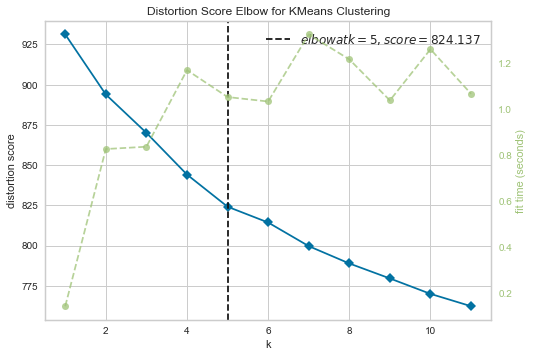

In [15]:
# k-means clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

X = tfidf_matrix

kmeanModel = KMeans()
    
visualizer = KElbowVisualizer(kmeanModel, k=(1,12))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [16]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 5

# number of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [17]:
# create DataFrame films from all of the input files.
product = { 'review': df[:1000].review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

In [18]:
frame.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,4
1,I love this watch it keeps time wonderfully.,4
2,Scratches,2
3,"It works well on me. However, I found cheaper ...",2
4,Beautiful watch face. The band looks nice all...,2
5,"i love this watch for my purpose, about the pe...",4
6,"for my wife and she loved it, looks great and ...",1
7,I was about to buy this thinking it was a Swis...,2
8,Watch is perfect. Rugged with the metal &#34;B...,1
9,Great quality and build.<br />The motors are r...,2


In [19]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
sentences = frame.iloc[0]["review"]
displacy.render(nlp(str(sentences)), style='dep', jupyter = True, options = {'distance': 120})

In [20]:
print("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,cluster
2,660
4,110
1,98
0,68
3,64


In [21]:
km.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00715048,
        0.        ],
       [0.00312279, 0.        , 0.        , ..., 0.0020914 , 0.00384477,
        0.01901532],
       [0.00563281, 0.00435844, 0.0015613 , ..., 0.00646265, 0.01728137,
        0.01364773],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00983297,
        0.        ],
       [0.        , 0.03506644, 0.03691985, ..., 0.01233269, 0.0143958 ,
        0.00403893]])

In [22]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
    print (", ".join(cluster_reviews))
    print ()

<Document clustering result by K-means>
Cluster 0 words:nice,price,simpl,realli nice,seller,realli,
Cluster 0 reviews (68 reviews): 
Nice watch, on time delivery from seller., It works well with nice simple look., Beyond my expectation..excellent product..good quality, well built, nicely done..:), vary nice, Very nice watch !!!, nice watch what you see on the picture is what you get, nice but it's a really noisy watch.<br />you will hear it all time... literally every second ..., Very nice watch for running, Nice, Nice, Good Nice watch, Nice desing. I love this watch., Nice, This is a nice sports watch.  Bigger than it looks on the picture, so it want disappoint if that's one of the desires in getting it., Very nice and reasonably price!, Nice watch, a little complicated getting set up, but has nice features, probably more than I'll ever use. Great looking!, Very nice, the nice watch, Very nice and simple!!!!, Nice watch. Not what I was expecting but that is not the sellers fault., Ver

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [23]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
# LDA requires integer values
tfidf_model_lda = CountVectorizer(max_df=0.99, max_features=500,
                                 min_df=0.01, stop_words='english',
                                 tokenizer=tokenization_and_stemming, ngram_range=(1,3))

tfidf_matrix_lda = tfidf_model_lda.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix_lda.shape[0]) + \
      " reviews and " + str(tfidf_matrix_lda.shape[1]) + " terms.")

In total, there are 1000 reviews and 264 terms.


In [25]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix_lda)
print(lda_output.shape)
print(lda_output)

(1000, 5)
[[0.89897335 0.02510571 0.02530833 0.02553523 0.02507739]
 [0.06814613 0.06715382 0.06964362 0.72823285 0.06682357]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [0.10000037 0.5999994  0.10000005 0.10000006 0.10000012]
 [0.0682606  0.72681131 0.07101067 0.06724749 0.06666992]
 [0.04045008 0.04039237 0.04067801 0.83808008 0.04039946]]


In [26]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(5, 264)
[[ 7.60083737 17.19400193 13.19447703 ...  0.20585042 22.00186374
   3.68205664]
 [ 1.58107375  0.200386    0.2003317  ...  5.89096052  1.40093956
   2.73908063]
 [ 5.68125199  0.20131359  0.20159017 ...  7.98373821 28.90989766
   1.09347412]
 [ 1.93023117  0.20145696  0.20155385 ...  0.20992363 19.48513343
  42.81475652]
 [ 0.20660572  0.20284152  0.20204724 ...  3.70952721  0.20216561
   6.67063209]]


In [27]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.90,0.03,0.03,0.03,0.03,0
Doc1,0.07,0.07,0.07,0.73,0.07,3
Doc2,0.20,0.20,0.20,0.20,0.20,0
Doc3,0.71,0.03,0.03,0.03,0.20,0
Doc4,0.01,0.19,0.36,0.43,0.01,3
Doc5,0.05,0.05,0.80,0.05,0.05,2
Doc6,0.02,0.02,0.92,0.02,0.02,2
Doc7,0.03,0.25,0.65,0.03,0.03,2
Doc8,0.66,0.01,0.01,0.13,0.18,0
Doc9,0.03,0.14,0.51,0.29,0.03,2


In [28]:
df_document_topic['topic'].value_counts().to_frame()

,topic
2,292
3,197
1,173
0,172
4,166


In [29]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model_lda.get_feature_names()
df_topic_words.index = topic_names

df_topic_words.head()

[[ 7.60083737 17.19400193 13.19447703 ...  0.20585042 22.00186374
   3.68205664]
 [ 1.58107375  0.200386    0.2003317  ...  5.89096052  1.40093956
   2.73908063]
 [ 5.68125199  0.20131359  0.20159017 ...  7.98373821 28.90989766
   1.09347412]
 [ 1.93023117  0.20145696  0.20155385 ...  0.20992363 19.48513343
  42.81475652]
 [ 0.20660572  0.20284152  0.20204724 ...  3.70952721  0.20216561
   6.67063209]]


,abl,absolut,absolut love,accur,actual,adjust,alarm,alreadi,alway,amaz,...,went,wife,wind,wish,work,work great,worn,worth,wrist,year
Topic0,7.600837,17.194002,13.194477,1.564469,0.203087,5.082461,4.551535,3.745981,0.202382,0.203038,...,0.202143,1.437451,6.214129,5.588538,15.925098,0.213258,9.571825,0.205850,22.001864,3.682057
Topic1,1.581074,0.200386,0.200332,0.204007,0.203108,8.027906,3.682810,0.206565,0.201629,5.188026,...,0.205060,4.333020,0.533761,5.802664,75.698631,0.200863,0.202337,5.890961,1.400940,2.739081
Topic2,5.681252,0.201314,0.201590,10.824661,8.458344,0.202899,0.202164,8.642907,7.972271,0.202390,...,4.066486,14.827204,0.202799,0.203991,0.304867,0.200318,0.202342,7.983738,28.909898,1.093474
Topic3,1.930231,0.201457,0.201554,0.205090,7.462482,11.484907,3.934323,0.202637,5.322127,0.201784,...,9.323943,0.201541,7.849212,0.202599,12.889463,0.201323,3.822869,0.209924,19.485133,42.814757
Topic4,0.206606,0.202842,0.202047,0.201773,0.672979,0.201827,4.629167,0.201910,0.301591,16.204761,...,0.202368,0.200783,0.200098,0.202207,29.181941,12.184237,0.200627,3.709527,0.202166,6.670632


In [30]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model_lda, lda_model=lda, n_words=30)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29
Topic 0,hand,wear,strap,second,beauti,fit,love,time,light,make,...,purchas,look,absolut,receiv,water resist,work,watch,easili,dark,use
Topic 1,good,work,band,use,look,qualiti,time,far,month,look good,...,good qualiti,chang,long,stop work,right,bad,design,size,broke,finish
Topic 2,look,great,band,love,nice,like,face,price,realli,cheap,...,comfort,big,came,size,easi,exact,think,buy,replac,featur
Topic 3,time,like,color,love,day,year,set,wear,big,watch,...,invicta,purchas,ca,return,need,larg,order,pretti,new,function
Topic 4,nice,product,great,price,excel,qualiti,perfect,work,expect,recommend,...,pleas,everyth,work great,replac,clock,littl,box,come,realli nice,time


# Part 6: Visualization

['hand', 'wear', 'strap', 'second', 'beauti', 'fit', 'love', 'time', 'light', 'make', 'water', 'hour', 'dial', 'wrist', 'perfect', 'comfort', 'great', 'resist', 'buy', 'second hand', 'purchas', 'look', 'absolut', 'receiv', 'water resist', 'work', 'watch', 'easili', 'dark', 'use', 'good', 'work', 'band', 'use', 'look', 'qualiti', 'time', 'far', 'month', 'look good', 'batteri', 'week', 'link', 'like', 'got', 'day', 'awesom', 'stop', 'bought', 'arriv', 'good qualiti', 'chang', 'long', 'stop work', 'right', 'bad', 'design', 'size', 'broke', 'finish', 'look', 'great', 'band', 'love', 'nice', 'like', 'face', 'price', 'realli', 'cheap', 'leather', 'pictur', 'look great', 'watch', 'wrist', 'feel', 'use', 'small', 'wear', 'star', 'comfort', 'big', 'came', 'size', 'easi', 'exact', 'think', 'buy', 'replac', 'featur', 'time', 'like', 'color', 'love', 'day', 'year', 'set', 'wear', 'big', 'watch', 'want', 'littl', 'read', 'realli', 'look', 'display', 'date', 'anoth', 'face', 'blue', 'invicta', 'purc

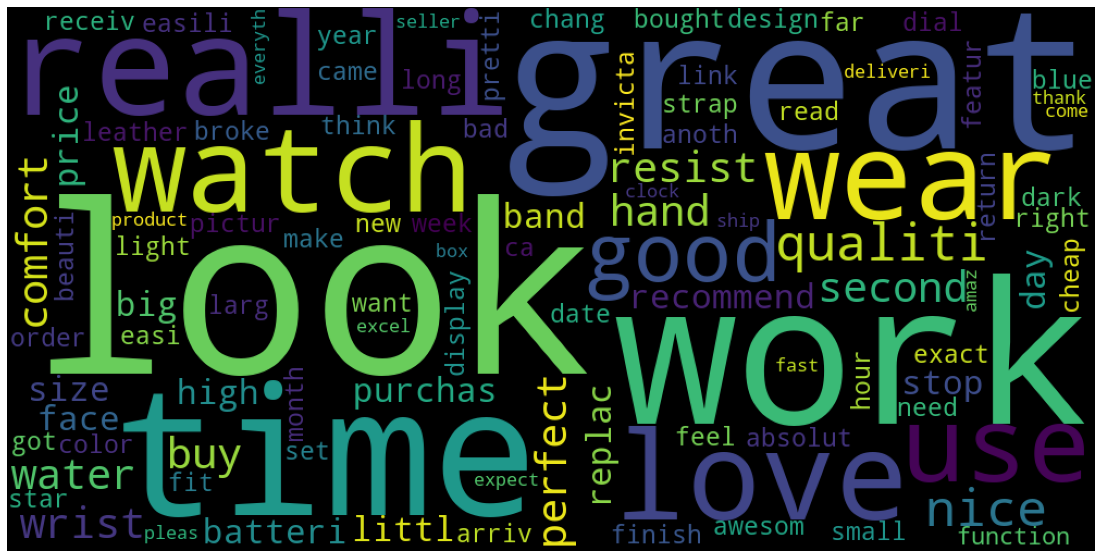

In [31]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud()
df = df_topic_words.iloc[:].values.tolist()
wordlist = []
for i in range(len(df)):
    wordlist += df[i]
print(wordlist)
for i in range(len(wordlist)):
    wordlist[i] = str(wordlist[i])


#convert list to string and generate
unique_string=(" ").join(wordlist)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(25,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("document_Clustering"+".png", bbox_inches='tight')
plt.show()
plt.close()